# CASA0006 DSSS: Final Assessment

**Author:** Joe Post  
**Student Number:** 22186870  
**Date:** April 2023  

**[Github repository](https://github.com/joepost/casa0006_assessment)**  

---

# Predicting crash severity using New Zealand transport data

**Abstract:** This notebook ...

## 1. Introduction

### 1.1 Background 

Text ...

### 1.2 Literature Review

Text ...

### 1.3 Research Question

Text ...

## 2. Methodology

Text

## 3. Data Analysis

### 3.1 Setup
To conduct the analysis, the below packages need to be imported.

In [5]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.3.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import (confusion_matrix, roc_auc_score, balanced_accuracy_score, accuracy_score,
                            precision_score, recall_score, classification_report)
from sklearn.inspection import permutation_importance

# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

# preprocessors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE   # run SMOTE (synthetic minority oversampling technique)
from imblearn.over_sampling import SMOTENC

# pipeline
from sklearn.pipeline import Pipeline as skPipeline
from imblearn.pipeline import Pipeline as imbPipeline

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

### 3.2 Data cleaning
#### Read data
The CSV file is read in as a pandas data frame, and columns changed to the appropriate data types.

In [220]:
# Read in data
df_raw = pd.read_csv("data/Crash_Analysis_System_CAS_data.csv", na_values = "Null")
df.shape

(323995, 61)

#### Clean missing data
The table below shows the default data type of imported columns, and a count of non-null values for each column. There are 807,933 observations (rows) in the dataset, and 72 features (columns).  

In [ ]:
# df.dtypes
df_raw.info()

Of these, 7 have a very high proportion of missing data (>90% of observations) - they are `advisorySpeed`, `crashRoadSideRoad`, `holiday`, `intersection`, `pedestrian`, `temporarySpeedLimit`, and `weatherB`. Through background reading of the [metadata](https://opendata-nzta.opendata.arcgis.com/pages/cas-data-field-descriptions), and investigation of the data, it can be seen that these columns contain a mix of true missing data and incorrectly coded real data. For example, `pedestrian` is defined as a "\[d\]erived variable to indicate how many pedestrians were involved in the crash. This includes pedestrians on skateboards, scooters and wheelchairs." However, non-missing values for `pedestrian` range from \[1,6\], meaning that no crash events have a value of '0' recorded. It is reasonable to assume that crashes with a null value for `pedestrian` actually represent events where no pedestrians were involved, as opposed to events where the number of pedestrians involved were not known or not recorded. Similarly, `holiday` only records an entry if the event falls into one of the four categories of Christmas/New Year, Easter, Labour Weekend, or Queens Birthday. Missing data in this column therefore likely represent events that occurred outside of these holiday dates. 

However, the columns `crashRoadSideRoad` and `intersection` are missing all data, and these were removed from the analysis. For `weatherB`, the observed possible values of 'Strong Wind', 'Frost', 'None' or missing do not align with the metadata description (where values are stated as 'Strong Wind', 'Frost' or 'Unknown'). Due to the ambiguity between 'None' and missing data, this column has been removed. 

For `temporarySpeedLimit` and `advisorySpeed`, missing data represents a true absence - in these cases, no temporary or advisory speed limit was in effect at the time and location of the crash event. Due to the low proportion of observations with a temporary or advisory speed limit in effect, these fields have been converted to boolean - where a present limit is True and no limit classed as False.

Finally, free-text columns have been removed as these will not be useful in the ML model, as well as a series of redundant fields where the information is contained in another variable. These are `OBJECTID`, `areaUnitID`, `crashDirectionDescription`, `crashFinancialYear`, `crashLocation1`, `crashLocation2`, `crashFinancialYear`, `meshblockId`, `tlaName` and `tlaId`.

In [ ]:
checkmissing = df_raw[["pedestrian", "advisorySpeed", 
                   # "holiday", "weatherB",        #commented out as these are non-numeric columns; see cells below
                   "crashRoadSideRoad", "intersection", "temporarySpeedLimit"]]
checkmissing.describe()

In [ ]:
df_raw['holiday'].unique()

In [ ]:
df_raw['weatherB'].unique()

In [ ]:
df_raw.drop(columns=['OBJECTID', 'areaUnitID', 'crashRoadSideRoad', 'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1', 'crashLocation2', 'meshblockId', 'tlaName', 'tlaId', 'intersection', 'weatherB'], inplace=True)   # drop unwanted columns
df_raw.pedestrian.fillna(value=0, inplace=True)     # replace missing pedestrian values with count of 0
df_raw.holiday.fillna(value="None", inplace=True)   # replace missing holiday values with category 'None'

In [ ]:
# TO DECIDE: fill missing values with unknown, OR impute with the mode? 

df_raw.streetLight.fillna(value="Unknown", inplace=True)   # replace missing streetLight values with category 'Unknown'
df_raw.weatherA.fillna(value="Unknown", inplace=True)  # replace missing weather values with category 'unknown'
df_raw.directionRoleDescription.fillna(value="Unknown", inplace=True)  # replace missing direction values with category 'unknown'
df_raw.flatHill.fillna(value="Unknown", inplace=True)  # replace missing hill status with category 'unknown'

In [ ]:
temporarySpeedLimit_bool = df_raw["temporarySpeedLimit"].notnull()
df_raw["temporarySpeedLimit_bool"] = temporarySpeedLimit_bool

advisorySpeed_bool = df_raw["advisorySpeed"].notnull()
df_raw["advisorySpeed_bool"] = advisorySpeed_bool

df_raw[["temporarySpeedLimit_bool","advisorySpeed_bool"]]

# REMOVE original tempspeed and advisoryspeed 
df_raw.drop(columns=['temporarySpeedLimit','advisorySpeed'], inplace=True)

A second subset of 23 columns have a non-null count of 325,939, meaning they are missing data for approximately 60% of observations. These are `bridge`, `cliffBank`, `debris`, `ditch`, `fence`, `guardRail`, `houseOrBuilding`, `kerb`, `objectThrownOrDropped`, `otherObject`, `overBank`, `parkedVehicle`, `phoneBoxEtc`, `postOrPole`, `roadworks`, `slipOrFlood`, `strayAnimal`, `trafficIsland`, `trafficSign`, `train`, `tree`, `vehicle`, and `waterRiver`. These columns all collect data on the number of objects of *type* that were struck in the crash, and are systematically either present or missing. Because of the large set of columns in this group, a subset of the dataframe has been created which keeps these columns but removes observations where they have missing data.

In [ ]:
# Set up list of columns with low/no missing data
columnsetA = ['bicycle', 'bus', 'carStationWagon',
           'crashSeverity', 'crashSHDescription', 'crashYear',
           'directionRoleDescription', 'fatalCount', 'flatHill', 'light',
           'minorInjuryCount', 'moped', 'motorcycle', 'NumberOfLanes',
           'otherVehicleType', 'pedestrian', 'region',
           'roadCharacter', 'roadLane', 'roadSurface', 'schoolBus',
           'seriousInjuryCount', 'speedLimit', 'streetLight', 'suv', 'taxi',
           'trafficControl', 'truck', 'unknownVehicleType', 'urban', 'vanOrUtility', 'weatherA']
    
# Set up list of columns with 60% missing data
columnsetB = ['bridge', 'cliffBank', 'debris', 'ditch', 'fence', 'guardRail',
           'houseOrBuilding', 'kerb', 'objectThrownOrDropped', 'otherObject', 'overBank',
           'parkedVehicle', 'phoneBoxEtc', 'postOrPole', 'roadworks', 'slipOrFlood', 'strayAnimal',
           'trafficIsland', 'trafficSign', 'train', 'tree','vehicle','waterRiver']

In [ ]:
# Set up subset of dataframe where rows missing data for ColumnSetB are removed
df_cb = df_raw.dropna(axis=0, subset=columnsetB)
df_cb.shape

In [ ]:
# Use this cell to define the analysis dataset (i.e. df_raw or df_cb)
# The default is to use the ColumnSetB subset
df = df_cb

After removing unnecessary columns and creating the ColumnSetB subset of the dataframe, the data is checked for any remaining missing values.

In [ ]:
n_total = df.X.count()
missing = pd.DataFrame(df.isna().sum(axis=0))
missing.rename(columns={0:'nullcount'}, inplace=True)
missing["null_pc"]=missing["nullcount"]/n_total

missing[missing["null_pc"]>0]

The missing values in these columns all represent a very small percentage (<0.05%) of the total observations. Therefore, these observations have been removed. 

In [ ]:
# remove any remaining observations with missing data
df = df.dropna(axis="index")
df.shape

#### Dependent variable
The outcome variable of interest for this study is the crash severity, which is measured by three variables: 
1. `crashSeverity`: categorised as Non-injury Crash, Minor Crash, Serious Crash, or Fatal Crash
1. `seriousInjuryCount`: count of the serious injuries associated with this crash
1. `fatalCount`: count of the fatal casualties associated with this crash

As fatal count and serious injury count are both heavily skewed towards zero, crash severity category will be used as the main dependent variable for the ML model. Of the four crash severity categories, there is a comparatively very low count of fatal crashes (<1%). Therefore, 'Fatal Crash' and 'Serious Crash' have been combined into a single category for the analyis. This reflects the approach taken in the literature, for example **PROVIDE REFERENCES**

In [ ]:
df['crashSeverity_3cat'] = np.where(df['crashSeverity']=='Fatal Crash', 'Serious/Fatal Crash', 
                                    np.where(df['crashSeverity']=='Serious Crash', 'Serious/Fatal Crash', 
                                             df['crashSeverity']))

df[["crashSeverity", "crashSeverity_3cat"]]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
# create chart in each subplot
sa1 = sns.countplot(data=df, x='crashSeverity', order=['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash'], ax=axes[0], palette="deep").set(
    title="Crashes by severity category", xlabel="Severity", ylabel="Count")
sa2 = sns.countplot(data=df, x='crashSeverity_3cat', order=['Non-Injury Crash', 'Minor Crash', 'Serious/Fatal Crash'], ax=axes[1], palette="pastel").set(
    title="Crashes by severity category \n (combined categories)", xlabel="Severity", ylabel="Count")

plt.show()

#### Set data types
Several columns in the dataset represent categorical data, where the input has been coded to one value out of a specific set - for example, the local government region where the crash occurred. Categorical columns in the dataframe are set accordingly, and the levels for each category checked to ensure it matches the metadata provided. 

The following columns are converted to categories:  
* `region`
* `crashSeverity`
* `crashSeverity_3cat`
* `crashSHDescription`
* `directionRoleDescription`
* `flatHill`
* `holiday`
* `light`
* `roadCharacter`
* `roadLane`
* `roadSurface`
* `streetLight`
* `trafficControl`
* `urban`
* `weatherA`
* `weatherB`

See below for a summary table (Table 1) of each categorical column, broken down proportionally by category. Tables 2 & 3 show the descriptive statistics for numeric variables, for column sets A and B, respectively.  

In [ ]:
# Convert category columns to category type
df = df.astype({
    "region":"category",
    "crashSeverity":"category",
    "crashSeverity_3cat":"category",
    "crashSHDescription":"category",
    "directionRoleDescription":"category",
    "flatHill":"category",
    "holiday":"category",
    "light":"category",
    "roadCharacter":"category",
    "roadLane":"category",
    "roadSurface":"category",
    "streetLight":"category",
    "trafficControl":"category",
    "urban":"category",
    "weatherA":"category"
})

catcols = ["region", "crashSeverity", "crashSeverity_3cat", "crashSHDescription", "directionRoleDescription", "flatHill",
           "holiday", "light", "roadCharacter", "roadLane", "roadSurface", "streetLight", "trafficControl", "urban", "weatherA", 
           # include boolean columns
          "temporarySpeedLimit_bool", "advisorySpeed_bool"]

##### Table 1.  Categorical variables in crash dataset

In [ ]:
# create loop of categorical variables to produce summary tables
for i in catcols:
    agg_df = df[[i, 'X']].groupby(i).count().rename(columns={'X':'count'}).sort_values('count', axis=0, ascending=False)
    total = agg_df.sum().values   # store the total as a value
    agg_df['percent'] = agg_df['count']/total*100   # calculate row-wise percentage
    print(agg_df)   # print table
    print("\n")

##### Table 2. Numeric variables in crash data set (Set A: low/no missing data)

In [ ]:
df[columnsetA].describe()

##### Table 3. Numeric variables in crash data set (Set B: approx. 60% missing data)

In [ ]:
df[columnsetB].describe()

#### Spatial conversion
The pandas dataframe is converted into a geopandas geodataframe, using the X/Y coordinates provided. These coordinates represent Easting/Northing values in the [NZTM2000](https://www.linz.govt.nz/guidance/geodetic-system/coordinate-systems-used-new-zealand/projections/new-zealand-transverse-mercator-2000-nztm2000) projection, which has the [EPSG code 2193](https://spatialreference.org/ref/epsg/2193/). The geodataframe is then plotted to confirm that the projection has been read as expected. 

In [ ]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y), crs = "EPSG:2193") 

<AxesSubplot:>

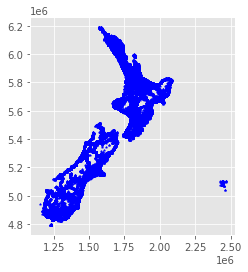

In [21]:
gdf.plot(marker='*', color='blue', markersize=5)

In [22]:
# TO REMOVE: (FUNCTION ADDED EARLIER IN SCRIPT)
## Set up subset of dataframe where rows missing data for ColumnSetB are removed
# gdf_cb = gdf.dropna(axis=0, subset=columnsetB)
# gdf_cb.shape

(325939, 62)

In [77]:
n_total = gdf_cb.X.count()
missing = pd.DataFrame(gdf_cb.isnull().sum(axis=0))
missing.rename(columns={0:'nullcount'}, inplace=True)
missing["null_pc"]=missing["nullcount"]/n_total

missing[missing["null_pc"]>0]

,nullcount,null_pc
advisorySpeed,305052,0.9359
directionRoleDescription,1551,0.0048
fatalCount,1,0.0000
flatHill,1944,0.0060
minorInjuryCount,1,0.0000
NumberOfLanes,636,0.0020
region,750,0.0023
roadLane,209,0.0006
roadSurface,385,0.0012
seriousInjuryCount,1,0.0000


### 3.X Fitting and evaluating a model
#### Training Testing Split
The first step in preparing a machine learning model is to split the dataset into a training and testing subsets. 

In [23]:
# Set inputs for model
data = gdf_cb    # alternative: full dataset 'gdf'
y_var = 'crashSeverity_3cat'

In [38]:
gdfX = data.drop(columns=['crashSeverity', 'crashSeverity_3cat', 'seriousInjuryCount', 'fatalCount'])  # create df containing only the predictor variables
gdfY = data[y_var]  # create array containing only the classifications/labels

random_state_split = 50
train_x, test_x, train_y, test_y = train_test_split(gdfX, gdfY, random_state=random_state_split)

In [ ]:
# Initiate SMOTE resampling
X_resampled, y_resampled = SMOTE().fit_resample(gdfX, gdfY)
print(sorted(Counter(y_resampled).items()))


In [25]:
print(f"Full dataset size: {data.shape}")

print("Training dataset size:")
print(train_x.shape)
print(train_y.shape)
      
print("Test dataset size:")
print(test_x.shape)
print(test_y.shape)

Full dataset size: (325939, 62)
Training dataset size:
(244454, 58)
(244454,)
Test dataset size:
(81485, 58)
(81485,)


#### Model Pipeline
To prepare the data for modelling, two pre-processing steps are run: imputation of missing values, and standardisation of numeric variables. Imputation replaces missing observations with the *median* value for that feature; median has been chosen over mean due to the numeric variables being heavily skewed towards zero. For categorical values, missing observations are replaced with the mode category. After defining the pre-processing steps, an estimator is added to the ML pipeline, which specifies the ML algorithms to be used. For this project, a remote forest classifier (Breiman 2001) has been chosen. 

**NOTE: Need to clarify**
* Is one-hot encoding necessary for RandomForest? (appears not to be; in fact can be detrimental)
* Attempt to run an RF model independently (without using pipeline method). See if error still occurs
* Additional steps - incorporate spatial dependence explicity into model, as in the case of *Effati (2015)*; this would involve calculating a new column of spatial autocorrelation, and including this as a feature in the ML (I think...)
* From [sklearn documentation](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use): Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. Class balancing can be done by sampling an equal number of samples from each class, or preferably by normalizing the sum of the sample weights (sample_weight) for each class to the same value. Also note that weight-based pre-pruning criteria, such as min_weight_fraction_leaf, will then be less biased toward dominant classes than criteria that are not aware of the sample weights, like min_samples_leaf.
* If the samples are weighted, it will be easier to optimize the tree structure using weight-based pre-pruning criterion such as min_weight_fraction_leaf, which ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights.
* Further steps: PCA, validation (cross-validation?), hyperparameter tuning - is it best to focus on RF method and just perform tuning for this? 

In [26]:
# Define preprocessors
numeric_transformer = imbPipeline(steps=[
       ('imputer', SimpleImputer(strategy='median')) # The missing values of a numeric feature will be replaced by the 'median'
      ,('scaler', StandardScaler())                  # standardises the values
])
categorical_transformer = imbPipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))  # The missing values of a categorical feature will be replaced by the mode (most frequent) category.
      ,('encoder', OneHotEncoder(drop='first'))         # drop 'first' refers to dropping the first of each category to use as the reference
])

In [27]:
# Prepare numeric and categorical column lists
numcols = list(set(columnsetA) - set(catcols)) + columnsetB   # create list of numeric columns
numcols.remove('seriousInjuryCount')   # remove the dependent variables  *NOTE: should these just be removed in the cleaning section?
numcols.remove('fatalCount')           # remove the dependent variables
catcols.remove('crashSeverity')        # remove the dependent variable
catcols.remove('crashSeverity_3cat')   # remove the dependent variable

catcols_index = [train_x.columns.get_loc(col) for col in catcols]

In [28]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numcols),          # tuple that sets out the name, the transformer to use, and the set of columns to include
        ('categorical', categorical_transformer, catcols)
    ])

In [29]:
# Combine preprocessor into pipeline
start_time = time.time()

pipeline = imbPipeline(steps = [
   ('column_preprocessor', column_preprocessor),
   ('smote', SMOTENC(catcols_index, random_state=50)),      # Adds oversampling process to Pipeline; HOWEVER NOT WORKING CURRENTLY - WILL FIT MODEL BUT NOT IMPROVE OUTCOME??
   ('classifier', RandomForestClassifier(class_weight="balanced"))  # sets RF with default hyperparameters
])

rf_model = pipeline.fit(train_x, train_y)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the hyperparameter tuning: {round((elapsed_time)/60,2)} minutes")

In [33]:
# Evaluate random forest model
print(f"Training score: {rf_model.score(train_x, train_y)}")
print(f"Test score: {rf_model.score(test_x, test_y)}")

Training score: 0.9959787935562519
Test score: 0.9223415352518869


**TO BE CONFIRMED**
The cell below is designed to compare a default RF with an RF with balanced class weights. However, the results in 'Balanced testing accuracy' do not show as much change as expected - why is this? (In the original tests of default RF run on its own, was producing a balanced accuracy around ~0.5). Need to decide whether it is worth keeping this in, or instead just keeping the original model fit above.   
Also overlaps with the section below 'Evaluating performance'.

In [76]:
# Compare multiple model variations in a single method
# classifiers = {
#     'RF': RandomForestClassifier(),
#     'RF_balanced': RandomForestClassifier(class_weight="balanced")
# }

# # a dict to store the evaluation output of training and testing data
# dict_results = dict()

# for name, classifier in classifiers.items():
#     pipeline = Pipeline(steps = [
#                ('preprocessor', preprocessor)
#               ,('classifier', classifier)
#            ])
#     model = pipeline.fit(train_x, train_y)
    
#     y_predict = model.predict(test_x)
#     y_predict_train = model.predict(train_x)
    
#     # predictions = model.predict(test_x)
#     dict_results[name] = [model.score(train_x, train_y),   # accuracy score of training data
#                           model.score(test_x, test_y),     # accuracy score of test data
#                           balanced_accuracy_score(train_y, y_predict_train),  # balanced accuracy 
#                           balanced_accuracy_score(test_y, y_predict),  # balanced accuracy 
#                          ]

# # transform dict_models to dataframe
# df_models = pd.DataFrame.from_dict(dict_results, orient='index', columns=['Training accuracy', 'Testing accuracy', 'Balanced training accuracy', 'Balanced testing accuracy'])
# df_models

#### Hyperparameter tuning
The following method finds the optimal values for RF hyperparameters, from the specified set. For this model, the best performing set used a max tree depth of 50 and a minimum leaf sample of 2.   

**NOTE:** The tuning cell takes approximately 40 minutes to run. Therefore, has been default set to not run, unless explicitly called by setting `run_tuning` to True.

In [2]:
# Set the below to 'True' to run the hyperparameter tuning cell
run_tuning = False

In [4]:
if run_tuning == True:
    start_time = time.time()
    
    # we fix the random_state in DecisionTreeClassifier() so that the result of GridSearchCV is the same in different runs
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight="balanced", random_state=50))  # sets RF with default hyperparameters
    ])
    
    pipeline.fit(train_x, train_y)
    
    # grid_params is the range of each hyperparameter
    grid_params = {  
        'classifier__max_depth': [10,20,50],   
        'classifier__min_samples_split': [2,4,8]   
    }
    search = GridSearchCV(pipeline, 
                      grid_params, 
                      verbose=2)    # controls the message output; v=2 computation time for each fold and parameter candidate are displayed
    search.fit(train_x, train_y)
    print("Best Score: ", search.best_score_)
    print("Best Params: ", search.best_params_)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the hyperparameter tuning: {round((elapsed_time)/60,2)} minutes")
    
else:
    print("Hyperparameter tuning not run.")

Hyperparameter tuning not run.


#### Evaluating performance
The `balanced_accuracy_score` function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets.

In [34]:
y_predict = rf_model.predict(test_x)
y_true = test_y

In [35]:
print(classification_report(y_true, y_predict))

                     precision    recall  f1-score   support

        Minor Crash       0.92      1.00      0.95     18267
   Non-Injury Crash       0.94      0.98      0.96     57136
Serious/Fatal Crash       0.43      0.13      0.21      6082

           accuracy                           0.92     81485
          macro avg       0.76      0.70      0.71     81485
       weighted avg       0.90      0.92      0.90     81485



"Precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples. The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label). The F-measure can be interpreted as a weighted harmonic mean of the precision and recall. A F measure reaches its best value at 1 and its worst score at 0. For an F1 measure, and the recall and the precision are equally important." [Source](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [36]:
print(f"The accuracy score is: {round(accuracy_score(y_true, y_predict),3)}")
print(f"The balanced accuracy score is: {round(balanced_accuracy_score(y_true, y_predict),3)}")

The accuracy score is: 0.922
The balanced accuracy score is: 0.705


Balanced accuracy score takes the average accuracy of each class, to account for evaluating imbalanced datasets (such as this one). The large disparity in estimates indicates that the raw accuracy is inflated due to the class imbalance, and that the model should incorporate weighting to address class imbalance and provide more robust estimates across all severity classes. 

#### Interpreting feature importance

Permutation feature importance (PFI) method. "Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set." [sklearn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

In [30]:
start_time = time.time()
result = permutation_importance(
    rf_model, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

# NOTE: Produces long runtime and error:
# /opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. 
# This can be caused by a too short worker timeout or by a memory leak.
#   warnings.warn(

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 2822.864 seconds


NameError: name 'feature_names' is not defined

In [ ]:
# print(forest_importances)

## 4. Discussion

Text ...


## 5. Conclusion

Text ...


## References

1. Breiman, L. (2001) ‘Random Forests’, *Machine Learning*, 45(1), pp. 5–32. Available at: https://doi.org/10.1023/A:1010933404324.
